## Predicting Highly Segregated Public Elementary Schools
**This notebook explores predicting highly segregated public schools in North Carolina.**
* Public schools may be highly minority or majority segregated.
* Using **NO** racial composition data, can we build a model to distinguish between public schools which are >= 80% minority or majority segregated?
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 


**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#import required Libraries
import pandas as pd
import numpy as np

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2014/Machine%20Learning%20Datasets/PublicElementarySchools2014_ML.csv"

path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2014/Machine Learning Datasets/PublicElementarySchools2014_ML.csv"
schData=pd.read_csv(path, low_memory=False)

#inspect data 
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Columns: 299 entries, student_num to unit_code
dtypes: float64(275), int64(24)
memory usage: 3.0 MB


In [2]:
#The MinorityPct field was removed from the _ML dataset for being highly correlated with other racial composition fields
#We will merge it back in to the _ML dataset, since this is our response variable. 
path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2014/School Datasets/PublicElementarySchools2014.csv"
responseData=pd.read_csv(path, low_memory=False)

responseData = responseData[['unit_code','MinorityPct']]

#inspect data 
responseData.info(verbose=False)

#Merge the response variable into our _ML data (schData)
schData = schData.merge(responseData,how='left',on='unit_code', suffixes=('', '_Drop'))

print('*********************************After: MinorityPct Added***********************')
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Columns: 2 entries, unit_code to MinorityPct
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
*********************************After: MinorityPct Added***********************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1300
Columns: 300 entries, student_num to MinorityPct
dtypes: float64(276), int64(24)
memory usage: 3.0 MB


## Looking at the Populations of Highly Segregated Schools in North Carolina
* First, we look at the count of public school campuses by minority percentage.  We can see there are schools at both extreme ends of the distribution. 
* Next, we look at the count of public school campuses by majority percentage.  Both charts show highly segregated minority and majority public school campuses with >= 80% segregation levels. 
* The final bar chart shows the counts of public school campuses with < 80% and >= 80% minority and majority segregation levels.    


In [3]:
#Create a response variable for the majority percentage
schData["MajorityPct"] = 1 - schData['MinorityPct']

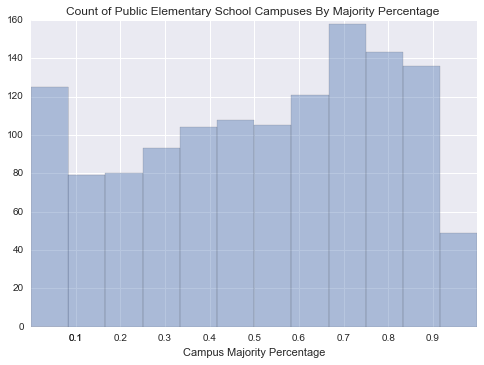

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
hst = sns.distplot(schData['MajorityPct'], kde=False)
hst.set_xlabel("Campus Majority Percentage")
#Assign output of plt.xticks() to x to surpress xticks() function output 
_ = plt.xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10])
_ = plt.title('Count of Public Elementary School Campuses By Majority Percentage ')

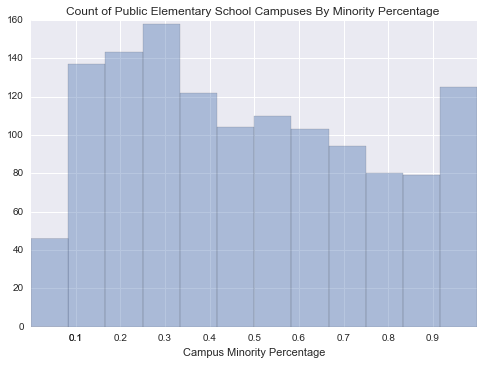

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
hst = sns.distplot(schData['MinorityPct'], kde=False)
hst.set_xlabel("Campus Minority Percentage")
#Assign output of plt.xticks() to x to surpress xticks() function output 
_ = plt.xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10])
_ = plt.title('Count of Public Elementary School Campuses By Minority Percentage ')

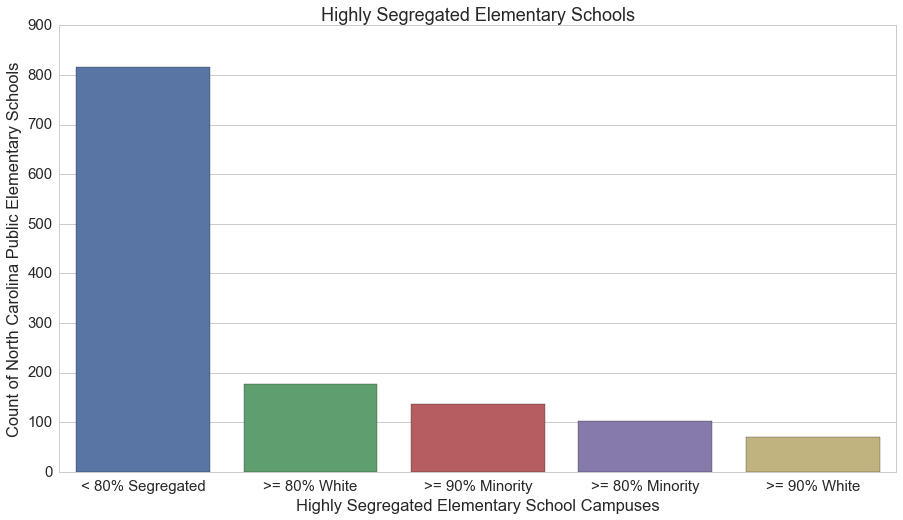

< 80% Segregated    815
>= 80% White        176
>= 90% Minority     137
>= 80% Minority     102
>= 90% White         71
Name: Segregated, dtype: int64


In [8]:
# Look at both highly segregated majority and minority campuses
hsegMajority = schData['MajorityPct'] >= 0.80
hsegMinority = schData['MinorityPct'] >= 0.80

schData.loc[(schData['MajorityPct'] >= 0.80),'Segregated'] = '>= 80% White'
schData.loc[(schData['MajorityPct'] >= 0.90),'Segregated'] = '>= 90% White'
schData.loc[(schData['MinorityPct'] >= 0.80),'Segregated'] = '>= 80% Minority'
schData.loc[(schData['MinorityPct'] >= 0.90),'Segregated'] = '>= 90% Minority'
schData.loc[(schData['MinorityPct'] < 0.80) & (schData['MajorityPct'] < 0.80),'Segregated'] = '< 80% Segregated'

# Set properties for bar plot
sns.set(context='notebook', style='whitegrid', font_scale=1.5)
fig, ax=plt.subplots(figsize=(15,8))

# Plot Barchart showing frequency of SPG Grades
sns.barplot(x=schData['Segregated'].value_counts().index,y=schData['Segregated'].value_counts())

# Set plot title, labels and legend
plt.xlabel('Highly Segregated Elementary School Campuses')
plt.ylabel('Count of North Carolina Public Elementary Schools')
plt.title('Highly Segregated Elementary Schools')
plt.show()

print schData['Segregated'].value_counts()

## Looking Closely at Highly Segregated Campuses
* Once we have isolated all public school campuses which are >= 80% majority or minority segregated, we create a new response variable flagging each highly segregated campus as highly minority or majority segregated. 
* **1** = a public school campus >= 80% minority segregated.
* **0** = a public school campus >= 80% majority segregated.
* We also isolate and **remove all campus racial composition** data from the remainder of our analysis.

In [9]:
#Get only highly segregated schools
schData = schData[(schData['Segregated'] != '< 80% Segregated')]
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 4 to 1300
Columns: 302 entries, student_num to Segregated
dtypes: float64(277), int64(24), object(1)
memory usage: 1.1+ MB


In [10]:
#Create a highly segregated flag where 1 = a > 80% minority campus and 0 = a > 80% majority campus 
schData.loc[(schData['MajorityPct'] >= 0.80),'HighlySegregatedTypeCd'] = 0
schData.loc[(schData['MinorityPct'] >= 0.80),'HighlySegregatedTypeCd'] = 1

#Check our results 
schData['HighlySegregatedTypeCd'].value_counts()

0.0    247
1.0    239
Name: HighlySegregatedTypeCd, dtype: int64

In [11]:
#Delete all racial composition data from our dataset. 
RaceCols = schData.columns[(schData.columns.str.lower().str.contains('indian')) | 
                           (schData.columns.str.lower().str.contains('asian')) |
                           (schData.columns.str.lower().str.contains('hispanic')) |
                           (schData.columns.str.lower().str.contains('black')) |
                           (schData.columns.str.lower().str.contains('white')) |
                           (schData.columns.str.lower().str.contains('pacificisland')) |
                           (schData.columns.str.lower().str.contains('twoormore')) |
                           (schData.columns.str.lower().str.contains('pacific island')) |
                           (schData.columns.str.lower().str.contains('two or  more')) |
                           (schData.columns.str.lower().str.contains('majority')) |
                           (schData.columns.str.lower().str.contains('minority')) |
                           (schData.columns.str.lower().str.contains('segregated'))]
RaceCols

Index([u'EOG/EOCSubjects_CACR_AmericanIndian', u'EOGGr3_CACR_AmericanIndian',
       u'EOGGr4_CACR_AmericanIndian', u'EOGGr5_CACR_AmericanIndian',
       u'EOGMathGr3_CACR_AmericanIndian', u'EOGMathGr3-8_CACR_AmericanIndian',
       u'EOGMathGr4_CACR_AmericanIndian', u'EOGMathGr5_CACR_AmericanIndian',
       u'EOGReadingGr3_CACR_AmericanIndian',
       u'EOGReadingGr3-8_CACR_AmericanIndian',
       ...
       u'PacificIslandFemalePct', u'PacificIslandMalePct', u'PacificIslandPct',
       u'TwoOrMoreFemalePct', u'TwoOrMoreMalePct', u'TwoOrMorePct',
       u'MinorityPct', u'MajorityPct', u'Segregated',
       u'HighlySegregatedTypeCd'],
      dtype='object', length=106)

In [12]:
# create x explanatory and y response variables for regression
Y_HighlySegregatedTp = schData['HighlySegregatedTypeCd'] 
Y = Y_HighlySegregatedTp

#Delete all racial composition data from our dataset.
X_PublicSchools = schData.drop(RaceCols, axis=1)

#inspect data 
X_PublicSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 4 to 1300
Columns: 197 entries, student_num to unit_code
dtypes: float64(173), int64(24)
memory usage: 751.8 KB


## Cross Validation
**Cross validation is performed using repeated holdout via ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [13]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Classifier Evaluation
** The following functions performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall, f1 score, and a confusion matrix for each model.** 

In [14]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_PublicSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_PublicSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print classReport
    print confMat
    print acc

## Highly Segregated Campuses - Logistic Regression 
**This model uses a Logistic Regression to classify public schools as >= 80% majority segregated or >= 80% minority segregated.** 
* All student body racial composition is removed from the model's training data. 
* A grid search is performed to determine the best parameters to use for the baseline model.

**Please see documentation here:**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [15]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_PublicSchools, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   21.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced', 'none']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [16]:
#Diplay the top model parameters
regGridSearch.best_estimator_

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [17]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_PublicSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.97347
The average precision for all cv folds is: 			 0.9621
The average recall for all cv folds is: 			 0.98325
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.979592,0.961538,1.000000
1,0.938776,0.888889,1.000000
2,0.979592,0.954545,1.000000
3,1.000000,1.000000,1.000000
4,0.979592,0.952381,1.000000
5,1.000000,1.000000,1.000000
6,0.897959,0.909091,0.869565
7,1.000000,1.000000,1.000000
8,0.979592,0.954545,1.000000
9,0.979592,1.000000,0.962963


In [18]:
EvaluateClassifierEstimator2(classifierEst, X_PublicSchools, Y, 10)

             precision    recall  f1-score   support

        0.0       0.95      0.90      0.92       247
        1.0       0.90      0.95      0.92       239

avg / total       0.93      0.92      0.92       486

[[222  25]
 [ 12 227]]
0.9238683127572016


# Top Performing Model Analisys
## Testing Scaled vs. Unscaled Training Data
**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is performed on the scaled training data to determine the best parameters to use with the scaled training data.
* We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately. 
* The scaled data makes more accurate predictions in many cases but not always!

In [19]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_PublicSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_PublicSchools_Scl = scaler.transform(X_PublicSchools)

**In this case, I tested scaling the data before cross validation as well.**

In [20]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_PublicSchools_Scl, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    8.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced', 'none']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [21]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [22]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_PublicSchools_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.96531
The average precision for all cv folds is: 			 0.95508
The average recall for all cv folds is: 			 0.97612
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.979592,0.961538,1.000000
1,0.959184,0.923077,1.000000
2,0.918367,0.869565,0.952381
3,0.979592,1.000000,0.958333
4,0.979592,0.952381,1.000000
5,1.000000,1.000000,1.000000
6,0.918367,0.880000,0.956522
7,0.938776,0.964286,0.931034
8,1.000000,1.000000,1.000000
9,0.979592,1.000000,0.962963


In [23]:
EvaluateClassifierEstimator2(classifierEst, X_PublicSchools_Scl, Y, 10)

             precision    recall  f1-score   support

        0.0       0.94      0.91      0.92       247
        1.0       0.91      0.94      0.92       239

avg / total       0.92      0.92      0.92       486

[[225  22]
 [ 15 224]]
0.9238683127572016


In [24]:
Y.value_counts()

0.0    247
1.0    239
Name: HighlySegregatedTypeCd, dtype: int64

## Feature Importance for the Top Performing Model
**Here we look at the features driving the top performing model's decisions.**
* The scaled training data removes differences in coefficient scales since many unscaled features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sorted by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations. 

In [25]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_PublicSchools_Scl, Y)

from sklearn.metrics import confusion_matrix

In [26]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_PublicSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

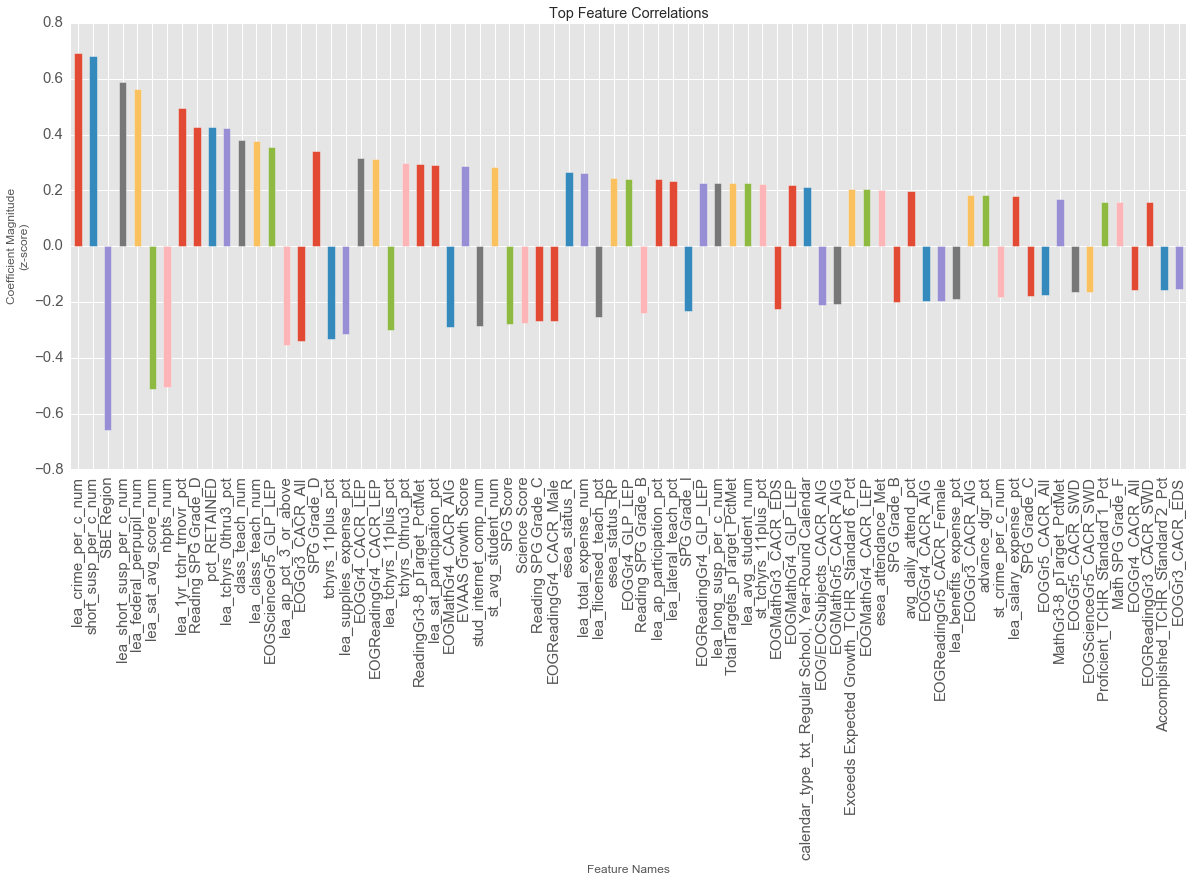

In [27]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## Using Recursive Feature Elimination
* Here we perform RFE to determine which features in the training data most accurately predict our response variable.  
* The chart below illustrates how ten-fold cross validation accuracy is impacted as features / columns are removed from the training data.  
* The optimal number of training features is then provided by the algorithm.   
* Features are ranked in the table below according to their impact on the model's accuracy.

**Please see the following documentation for this section**
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
* http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [28]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_PublicSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
   estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 157


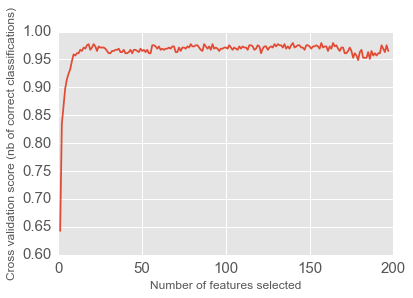

In [29]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [30]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_PublicSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
156,Developing_TCHR_Standard 5_Pct,0.979592
163,Exceeds Expected Growth_TCHR_Standard 6_Pct,0.979592
139,lea_1yr_tchr_trnovr_pct,0.979592
17,EOGGr4_CACR_All,0.977551
78,EOGMathGr4_GLP_SWD,0.977551
128,class_teach_num,0.977551
130,advance_dgr_pct,0.977551
91,EOG/EOCSubjects_CACR_AIG,0.977551
20,EOGMathGr5_CACR_Female,0.977551
86,EOGReadingGr4_GLP_SWD,0.977551


## Putting it all together!
** Here we use the best features uncovered by recursive feature elimination to create a final model with optimized grid search parameters and scale the data to perform feature importance analisys.**

** The following steps are performed:**
1. Use recursive feature elimination to select the best features for predicting highly majority segregated schools.
2. Create a pipeline to scale the training data then perform logistic regression.
3. Create logistic regression parameters to test within the pipeline. 
4. Use a grid search to find the best parameters based on classification accuracy. 
5. Perform 10-fold cross validation and look at individual fold performance.  
6. Look at the classification report, confusion_matrix, and accuracy_score from sklearn.metrics for detailed performance analysis.

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier, but I am including it again below in comment for a complete example!)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X_PublicSchools, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [32]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.99184
The average precision for all cv folds is: 			 0.98707
The average recall for all cv folds is: 			 0.996
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.959184,0.960000,0.96
1,1.000000,1.000000,1.00
2,1.000000,1.000000,1.00
3,1.000000,1.000000,1.00
4,0.979592,0.952381,1.00
5,1.000000,1.000000,1.00
6,0.979592,0.958333,1.00
7,1.000000,1.000000,1.00
8,1.000000,1.000000,1.00
9,1.000000,1.000000,1.00


In [33]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       247
        1.0       0.99      0.99      0.99       239

avg / total       0.99      0.99      0.99       486

[[245   2]
 [  3 236]]
0.9897119341563786


## Looking at RFECV Feature Importance after using a Pipeline
** Here we look at the top features selected during recursive feature elimination. The features are ranked based on importance using coefficients from the top performing pipeline model identified above.**

** This code is identical to the previous feature importance code, with the exception of the first two lines:** 
* **Line 1** - Gets coefficients from the top performing grid search model: grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
* **Line 2** - Uses the recursive feature elimination mask:get_support(indices=True) to get the column names of the top features selected from the original dataset: X_PublicSchools  

In [34]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = X_PublicSchools.columns.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

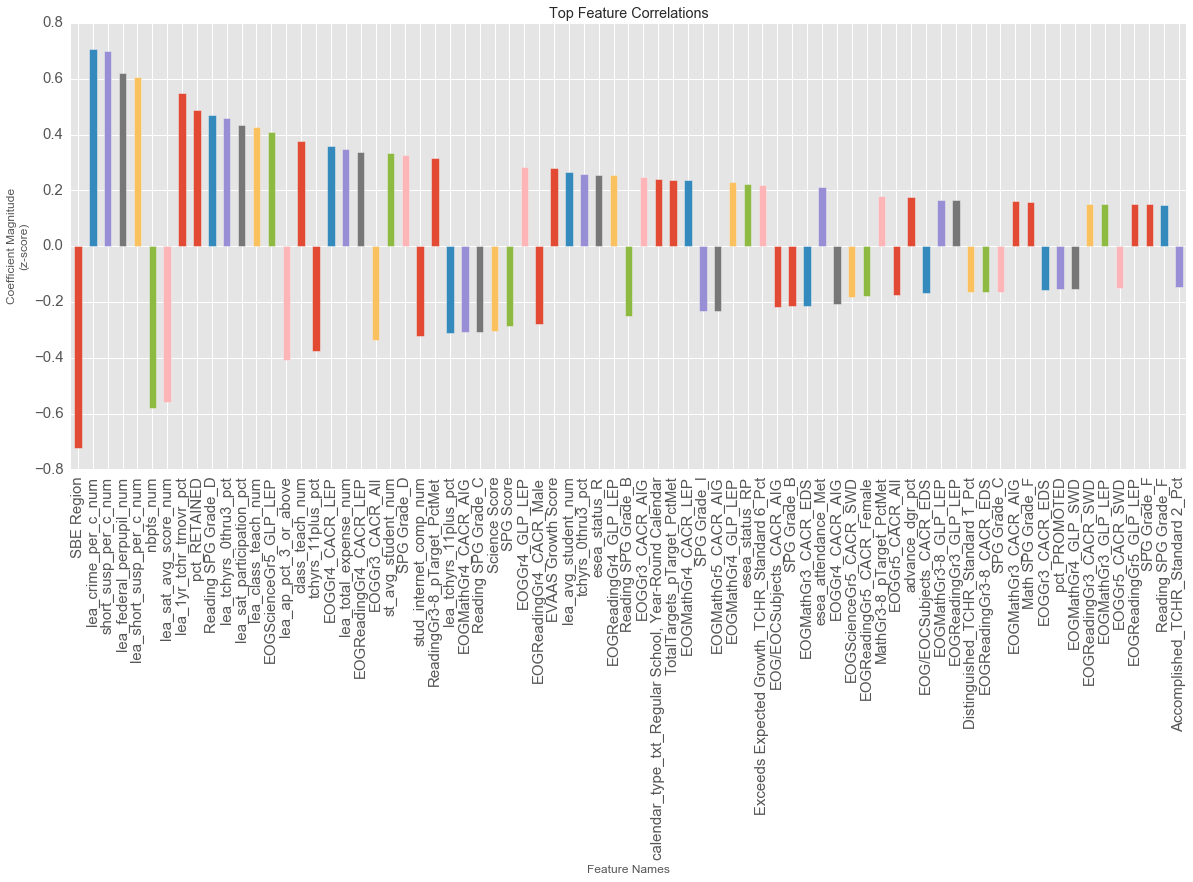

In [35]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## Comparing the Top 50 Features Used to Distinguish Between Public Schools with >= 80% Majority and Minority Student Body Racial Compositions
** Highly majority and minority segregated public schools are compared to evaluate the differences between predominately white and predominately minority concentrated campuses.**


**Key questions to consider when reviewing this data:**
* How big is the problem? 
* How many highly majority and minority segregated campuses exist in the State of North Carolina?
* Are the minority and majority populations treated differently?
* Which type of campus would you prefer your children to attend after reviewing the charts below?

In [36]:
#Get top 50 columns to compare 
top_feature_names = linreg_ft_imp_df.head(50)

#Create categorical plot value for highly segregated schools 
schData.loc[(schData['HighlySegregatedTypeCd'] == 0),'HighlySegregatedType'] = '>= 80% Majority'
schData.loc[(schData['HighlySegregatedTypeCd'] == 1),'HighlySegregatedType'] = '>= 80% Minority'

#Create dataframe with only the top 50 columns + our response variable 
col_names = top_feature_names['feature_names'].ravel()
col_names = np.append(col_names, 'HighlySegregatedType')

top_features_df = schData[col_names]
top_features_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 4 to 1300
Columns: 51 entries, SBE Region to HighlySegregatedType
dtypes: float64(41), int64(9), object(1)
memory usage: 217.4+ KB


In [37]:
#Isolate bool and float columns 
boolMask = top_features_df.dtypes == np.int64 
continuousMask = top_features_df.dtypes == np.float64 

#Add back the response variable
boolMask['HighlySegregatedType'] = True
continuousMask['HighlySegregatedType'] = True

#Create bool and float datafromes for plots
topBool = top_features_df.loc[:,boolMask]
topContinuous = top_features_df.loc[:,continuousMask]

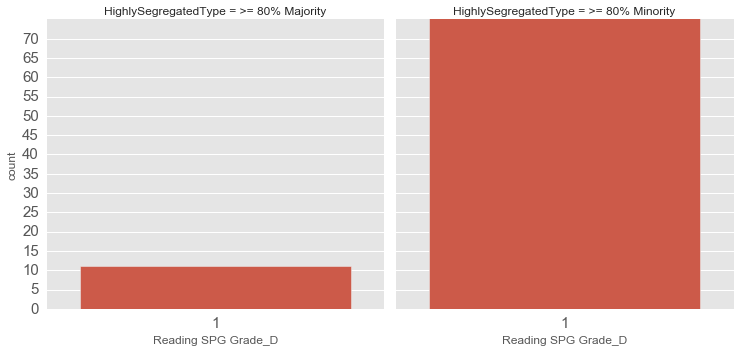

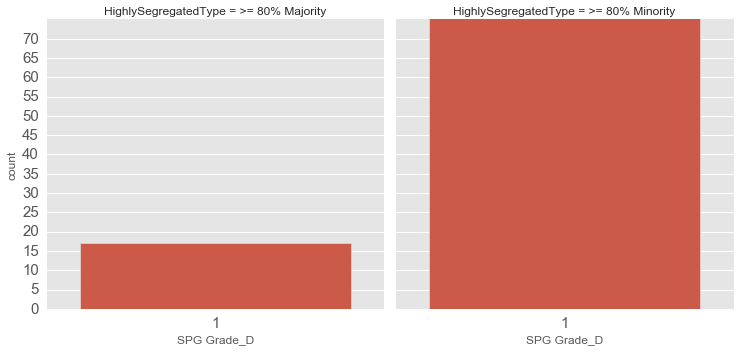

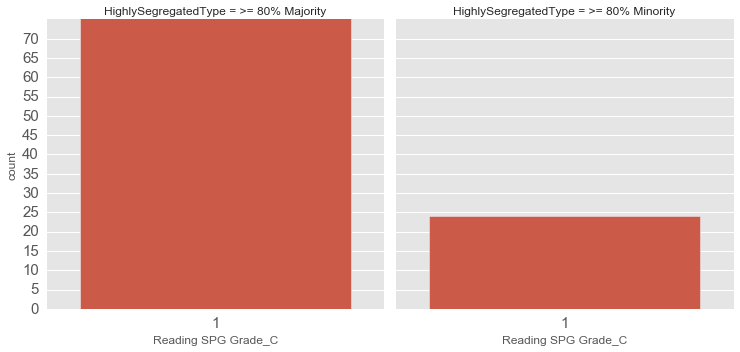

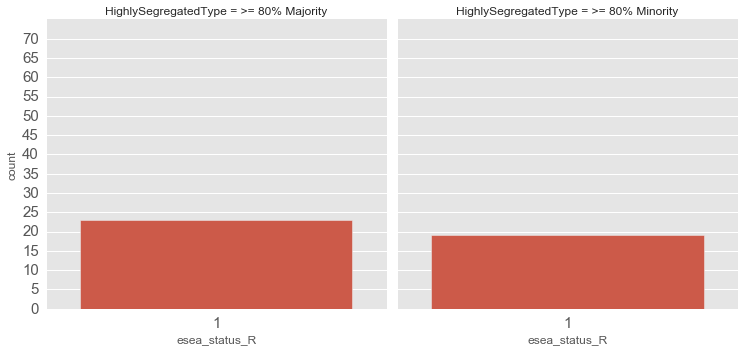

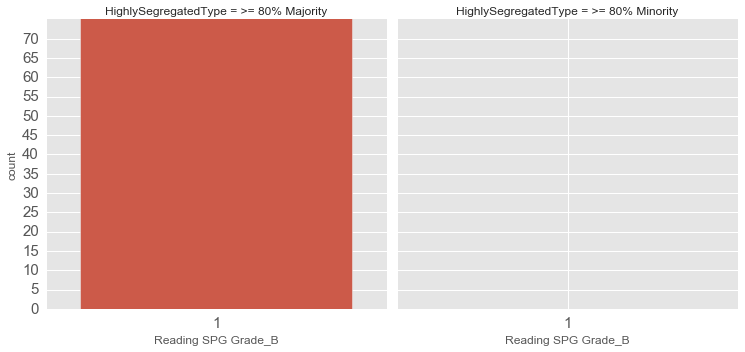

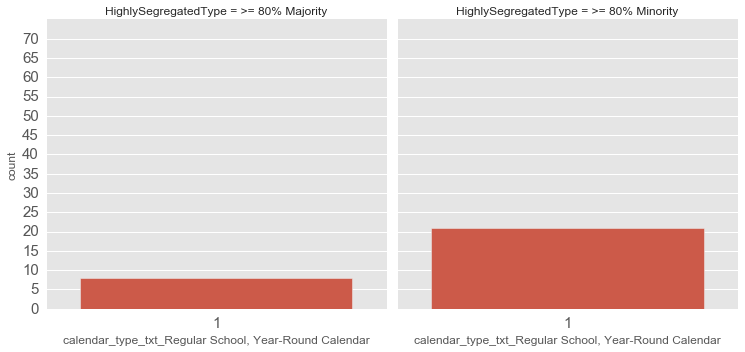

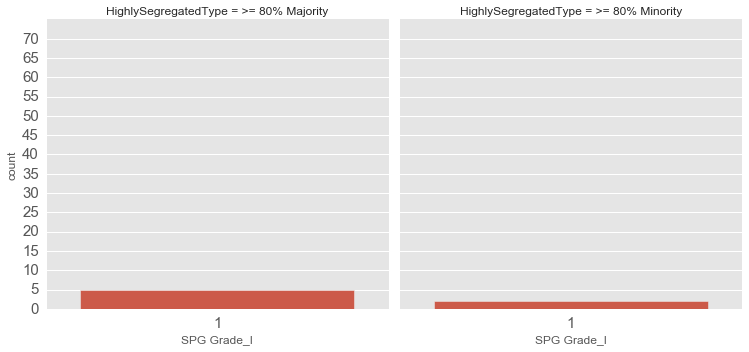

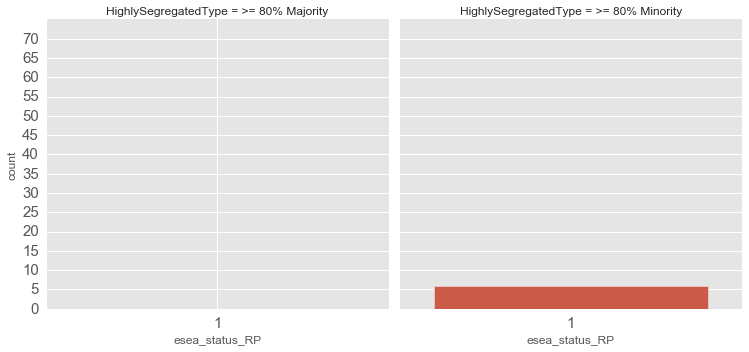

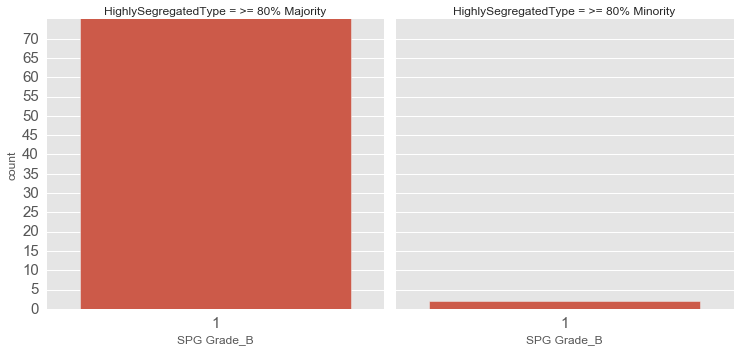

In [38]:
#Create count plots for all of our binary flags == 1 
for col in top_features_df.loc[:,boolMask].columns.values[:-1]:
    g = sns.factorplot(x=col, col="HighlySegregatedType", col_wrap=4,
                   data=topBool[topBool[col] == 1], kind="count", size=5, aspect=1, col_order=[">= 80% Majority",">= 80% Minority"])
    sns.plt.ylim(0, 75)
    sns.plt.yticks(np.arange(0, 71, 5.0))


In [41]:
if len(top_features_df.loc[:,boolMask].columns.values[:-1]) == 0:
    print "There are no binary features in this model!"

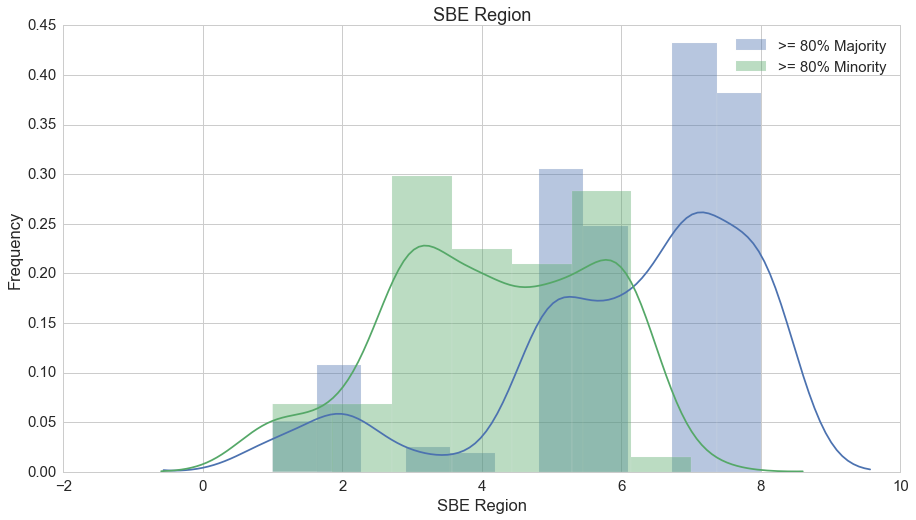

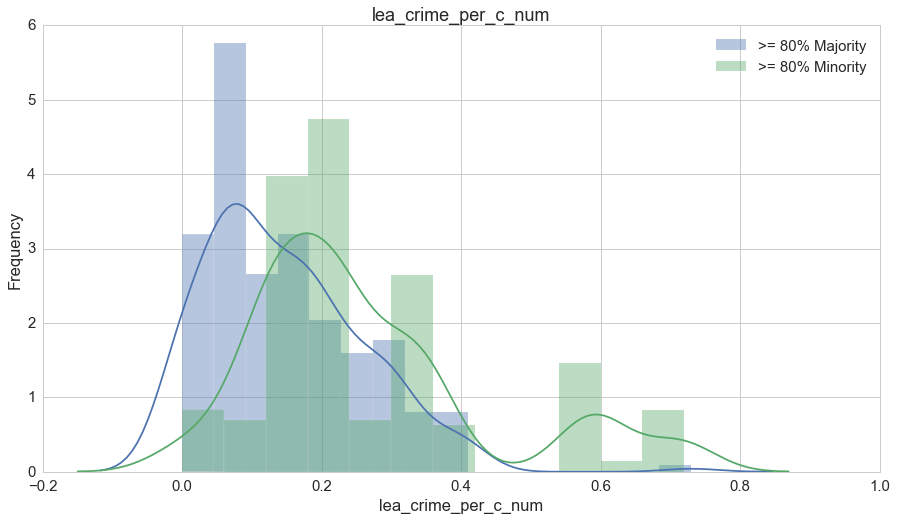

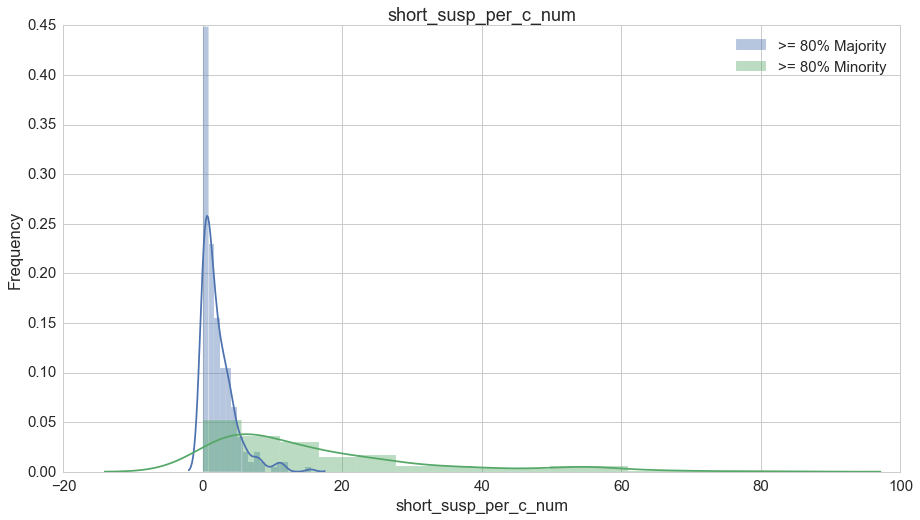

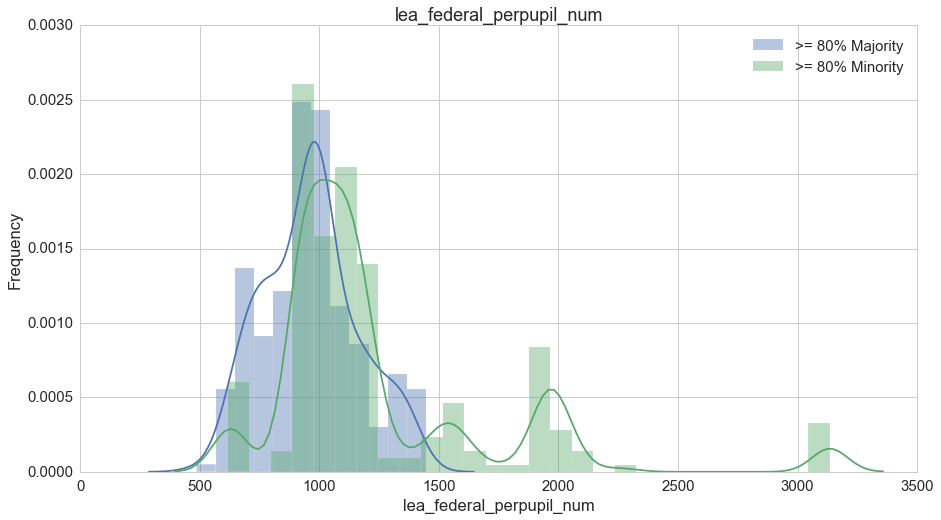

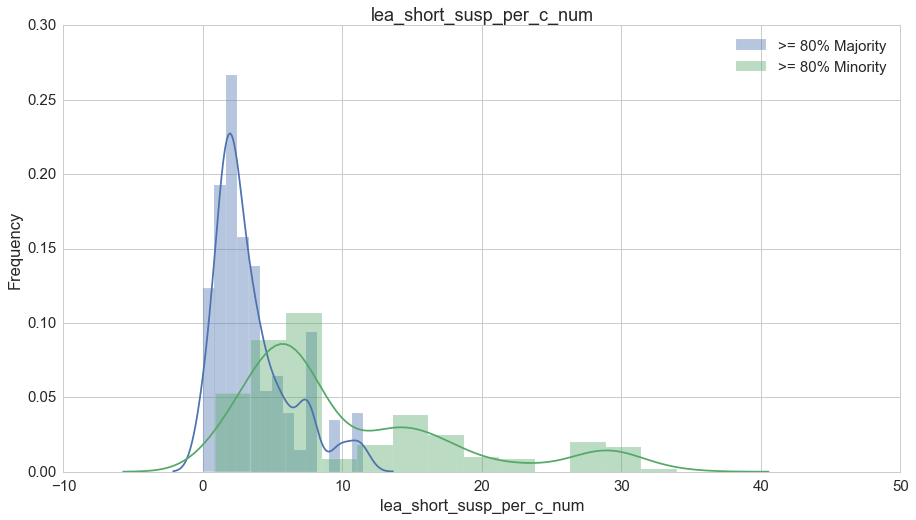

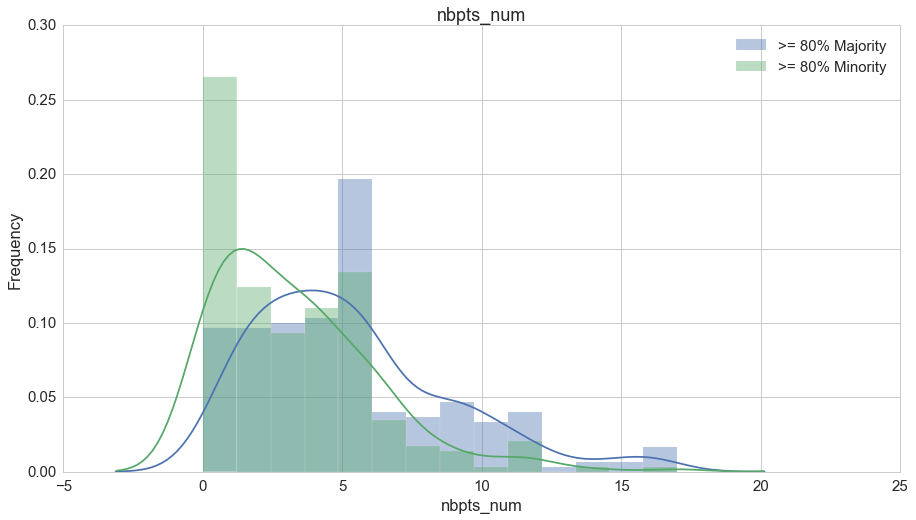

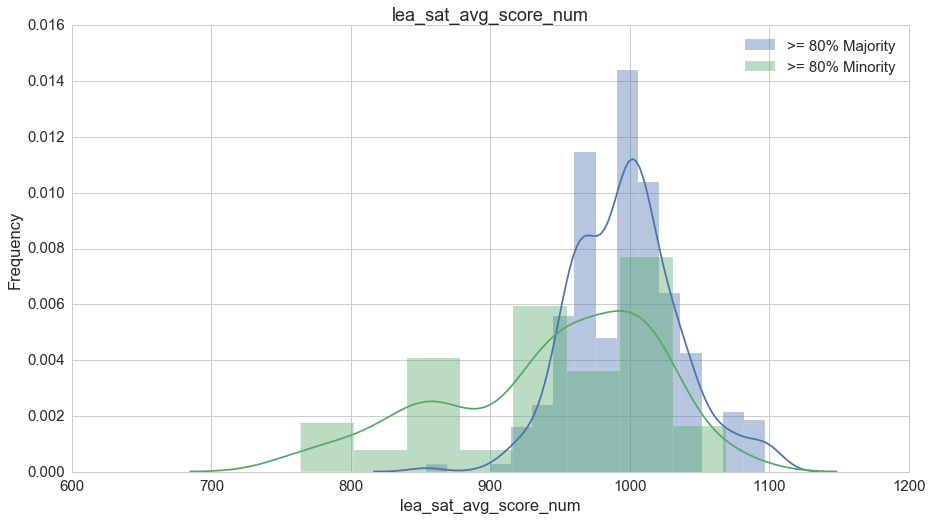

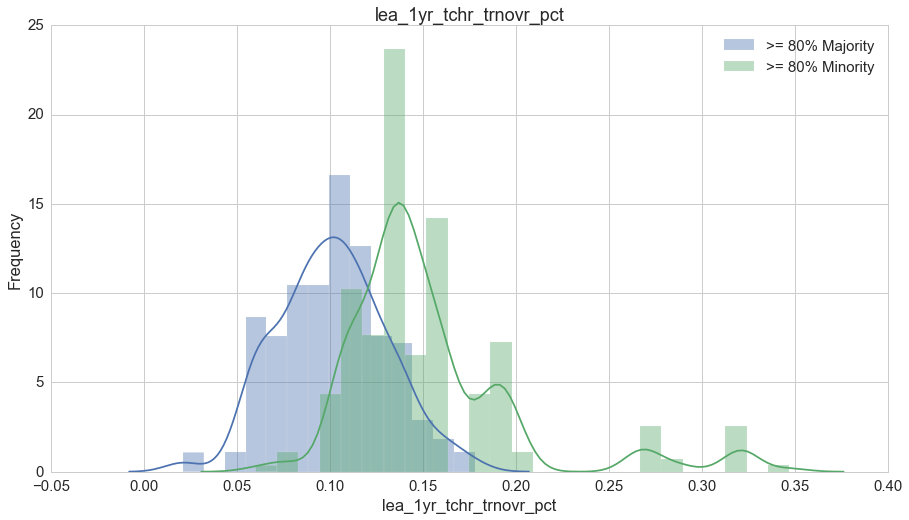

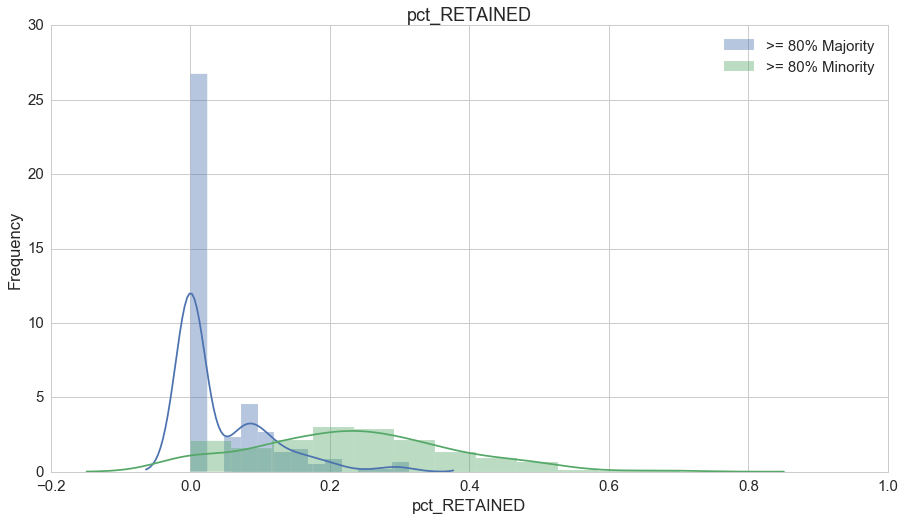

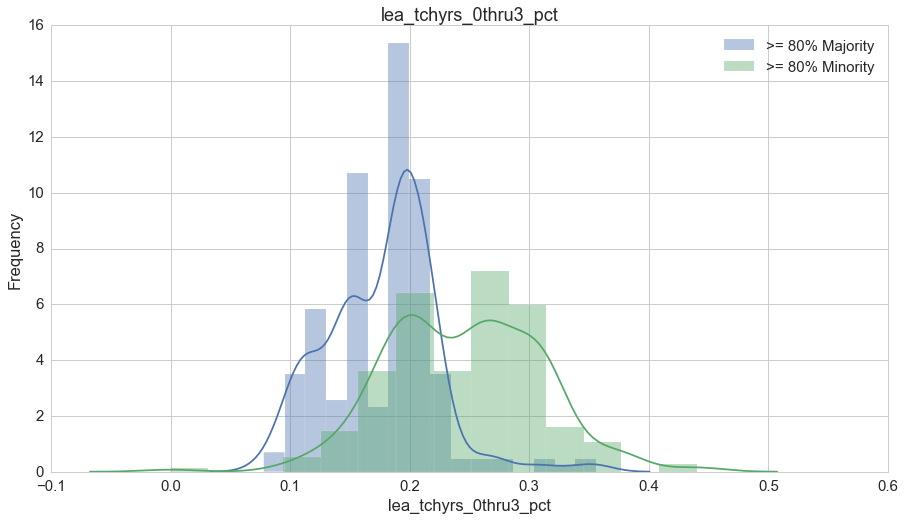

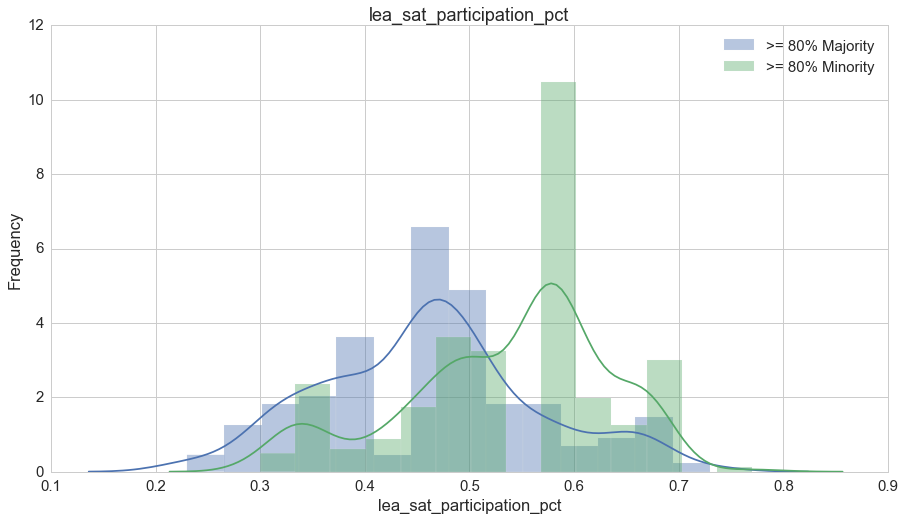

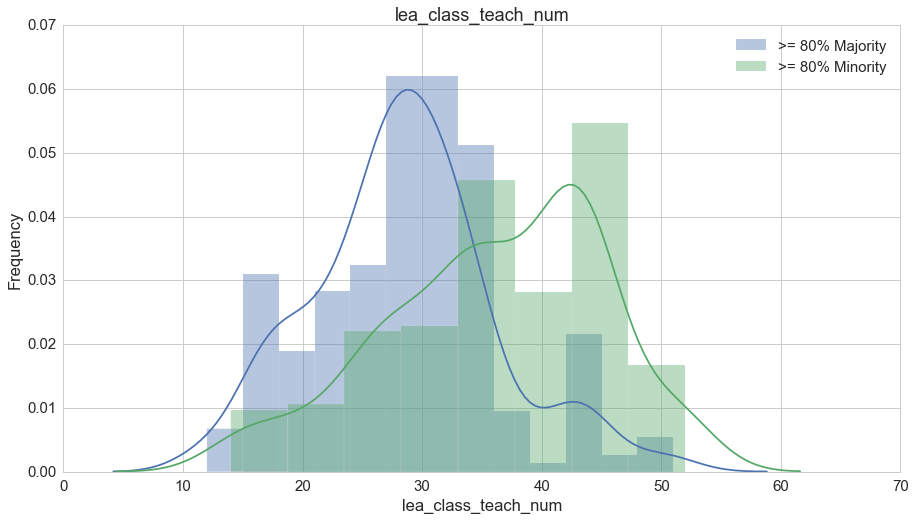

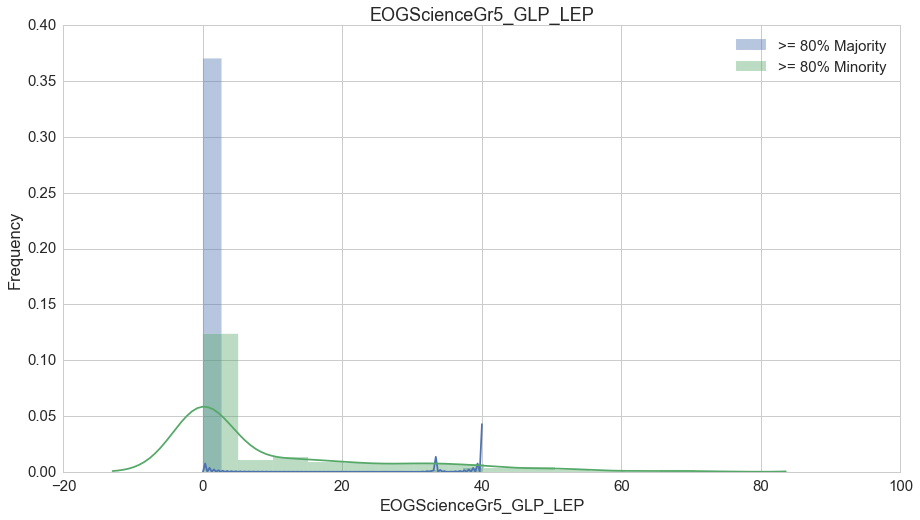

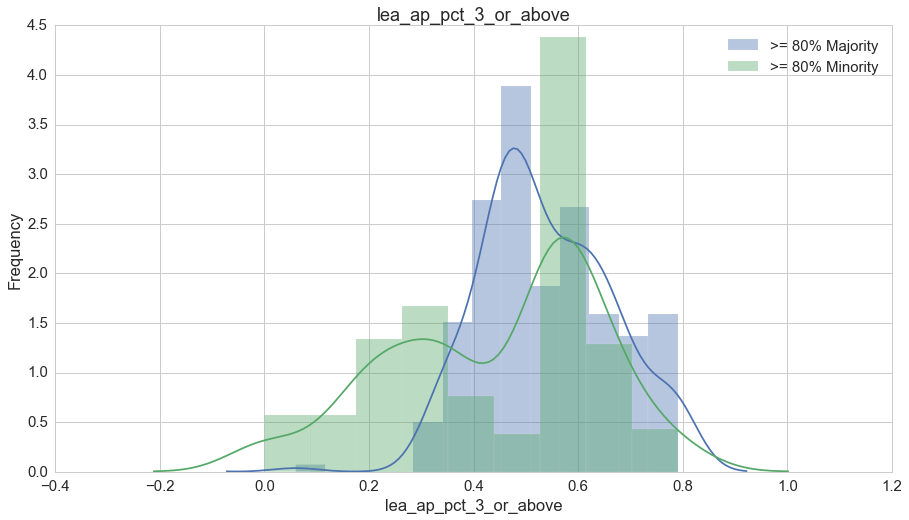

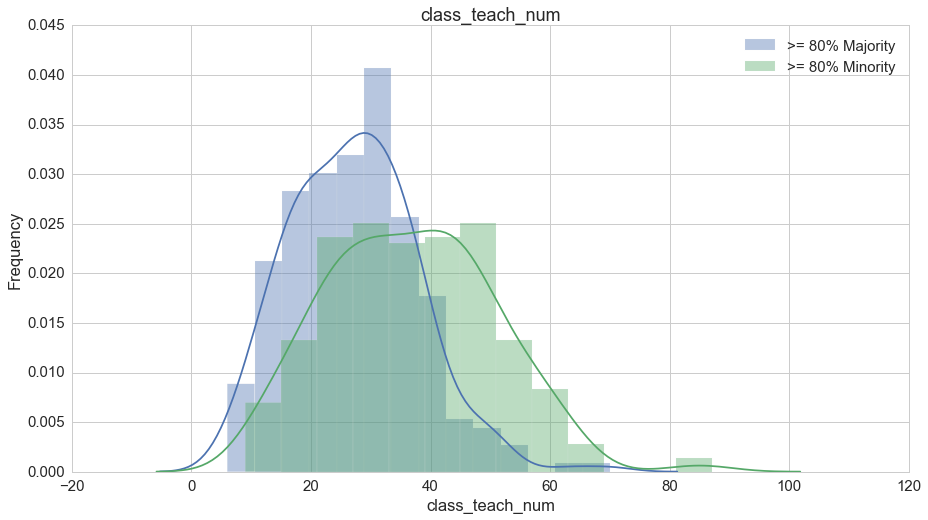

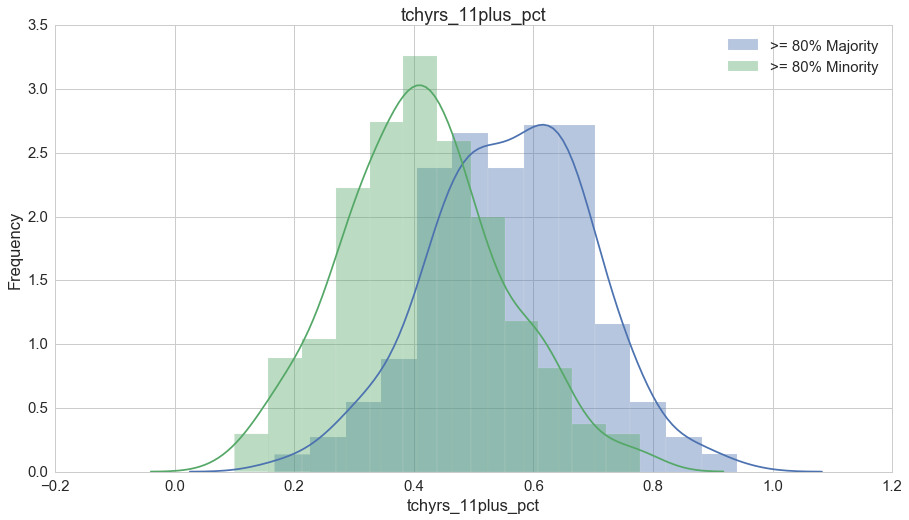

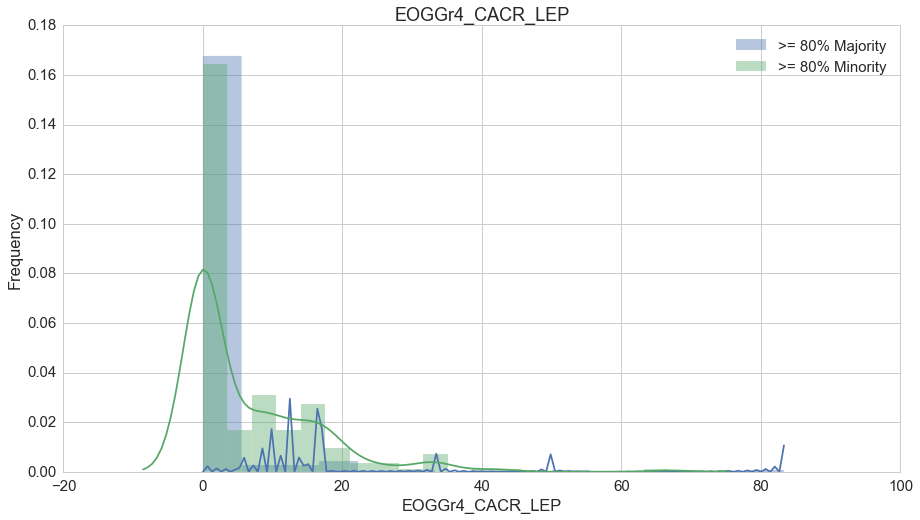

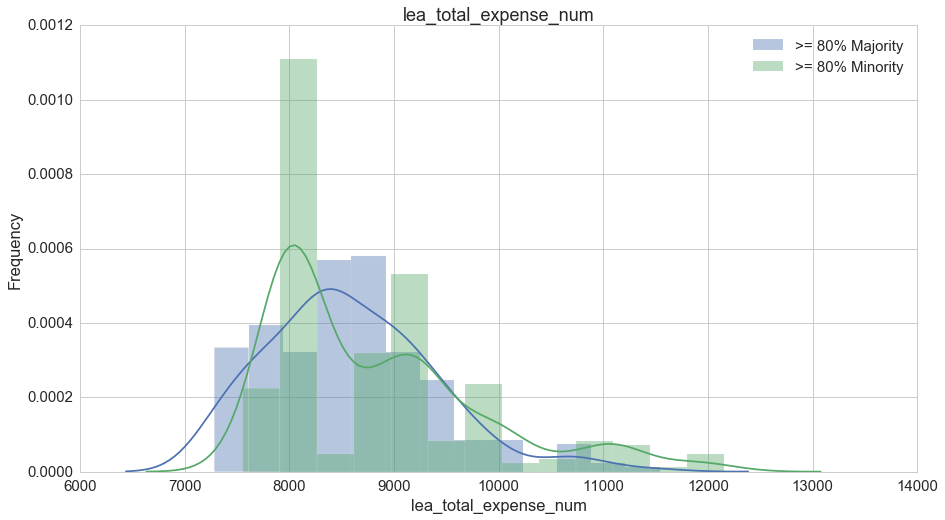

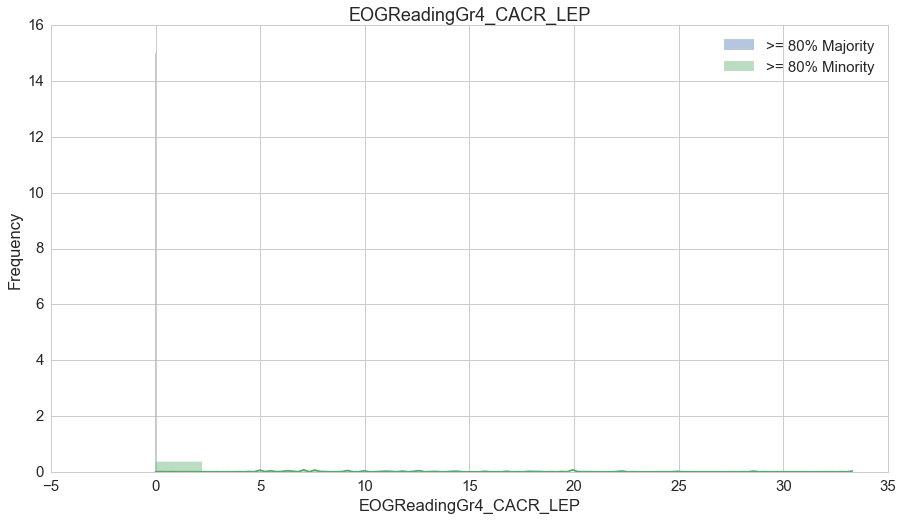

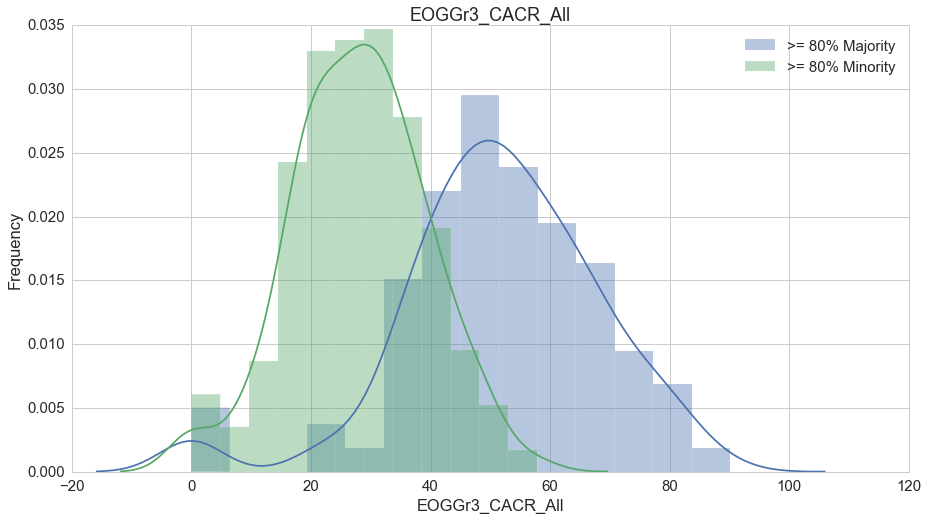

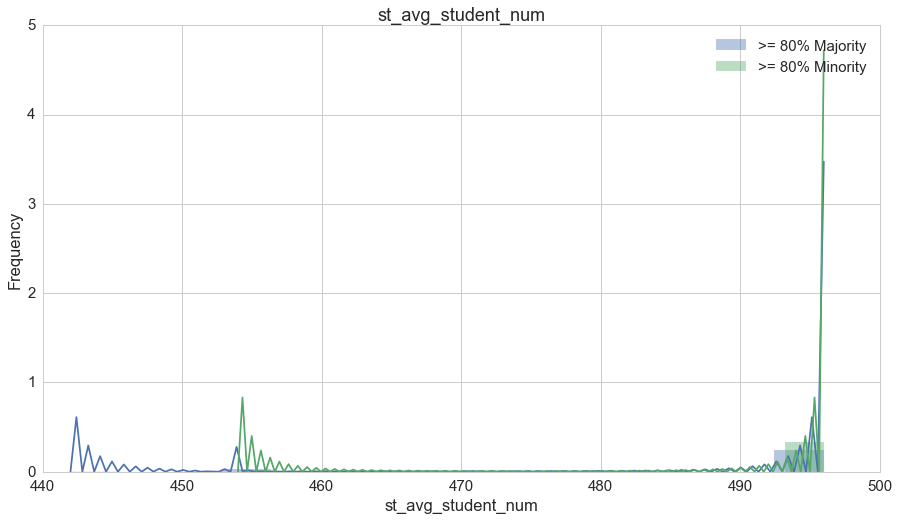

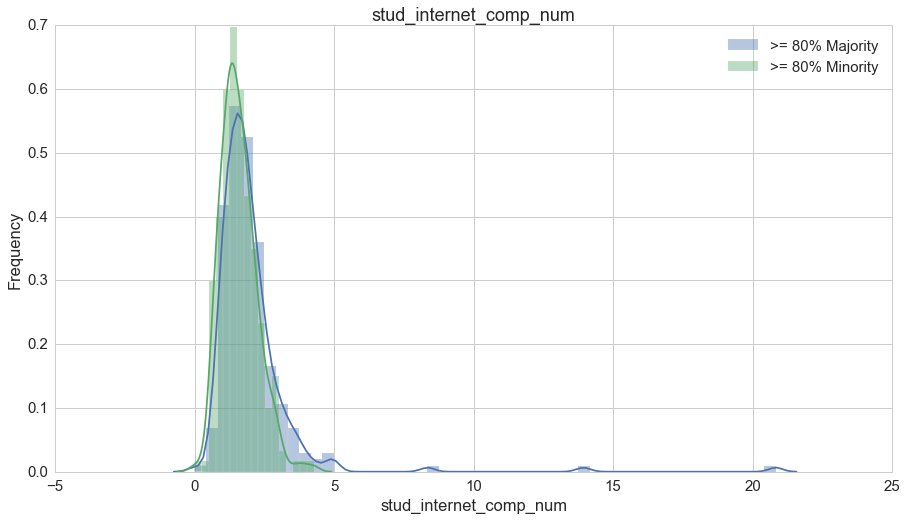

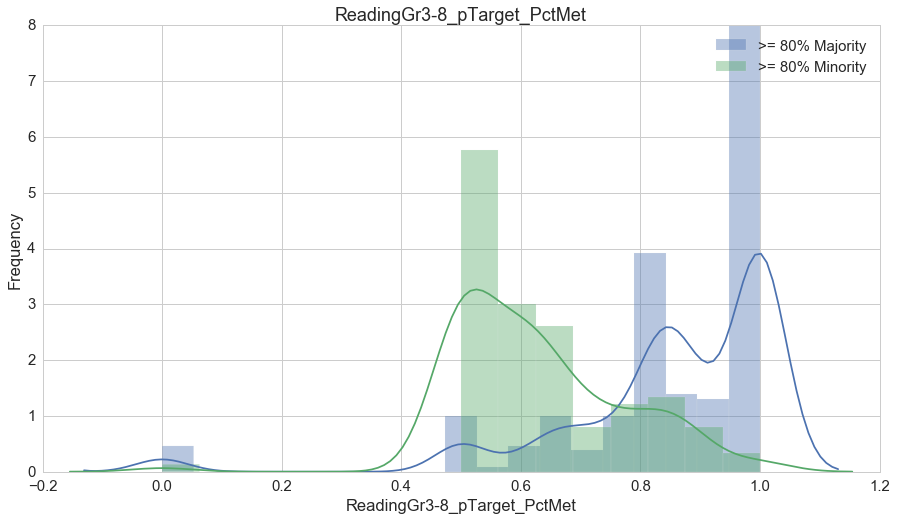

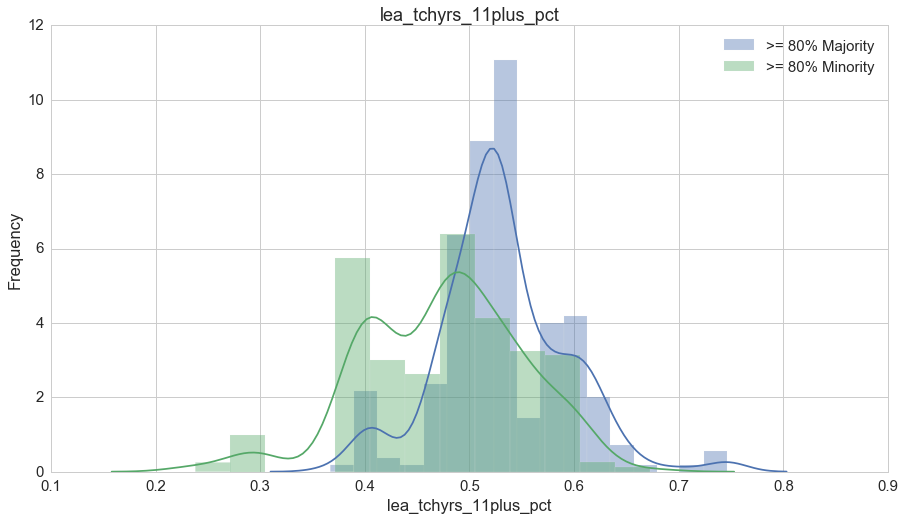

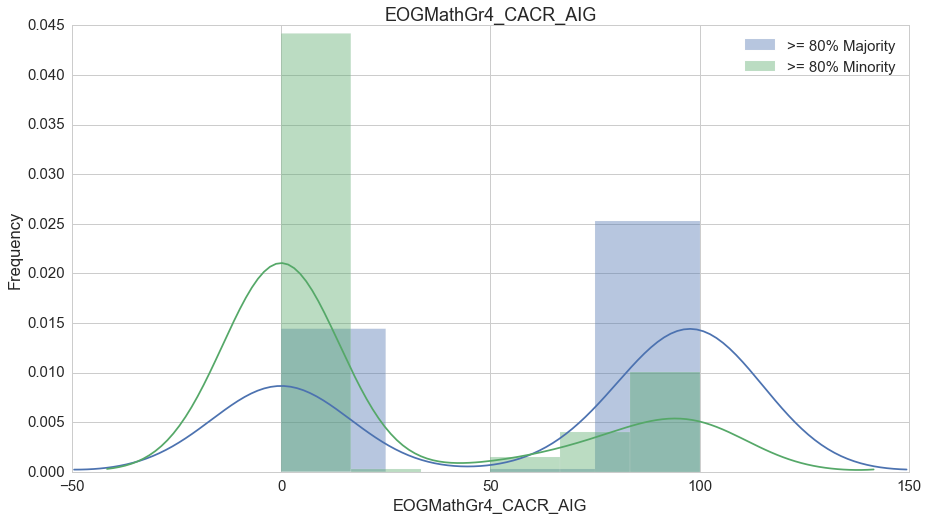

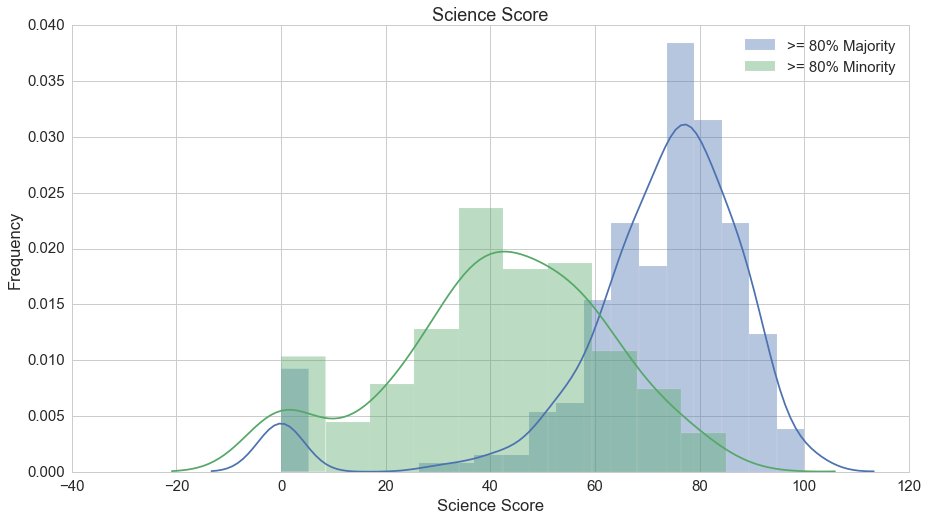

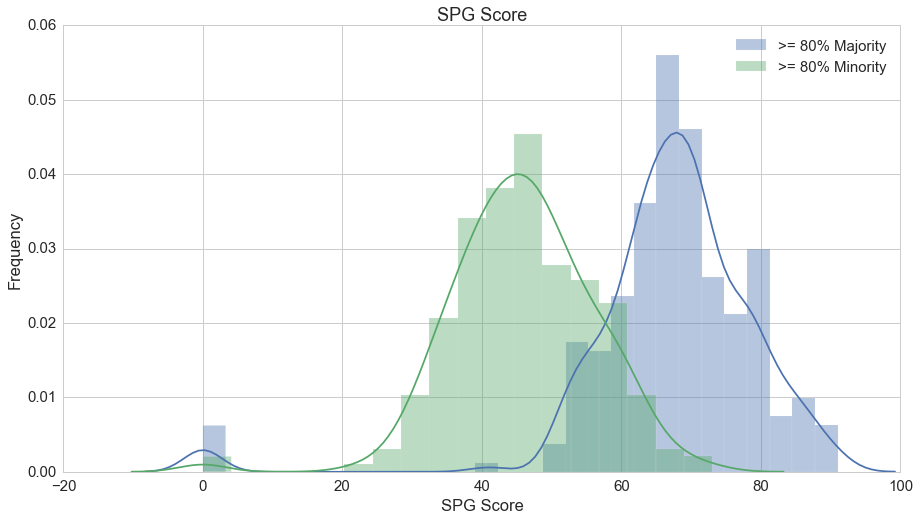

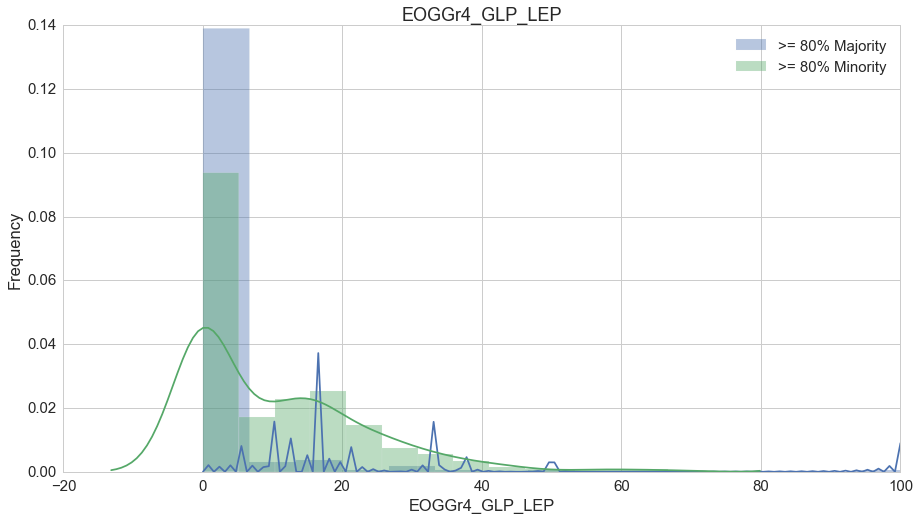

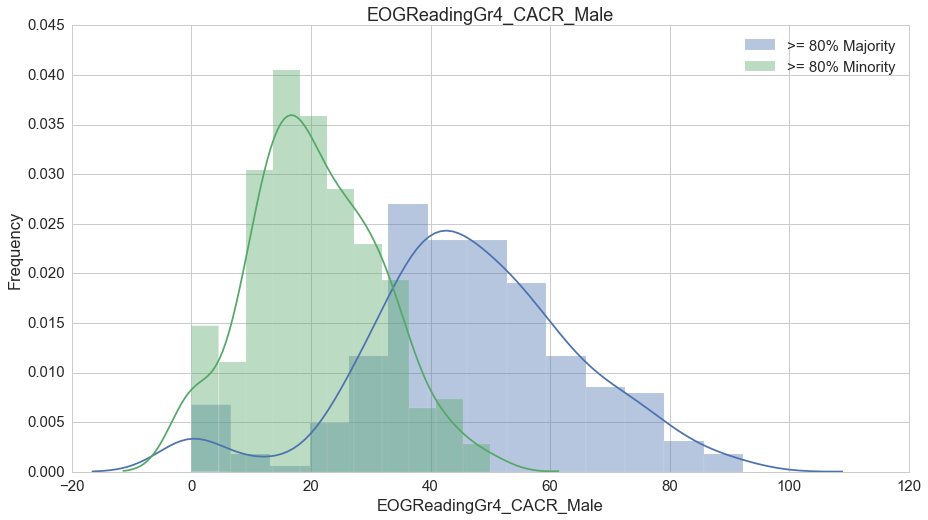

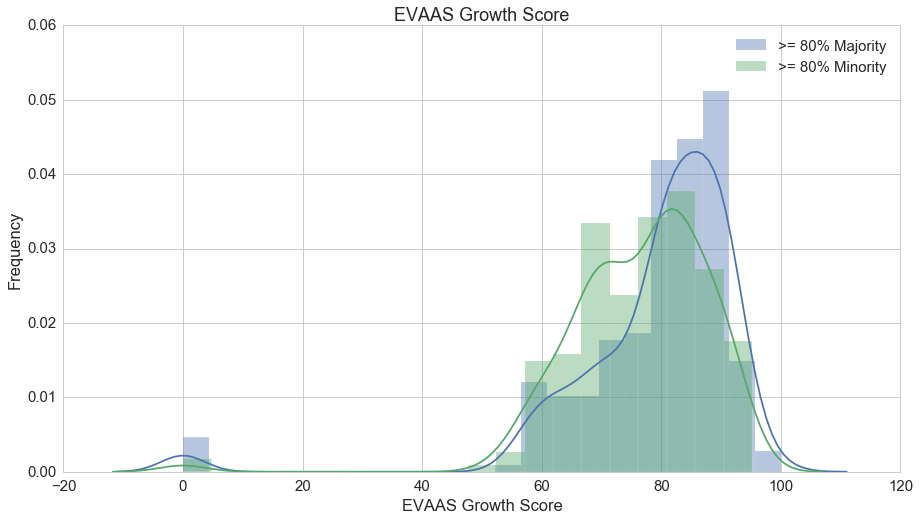

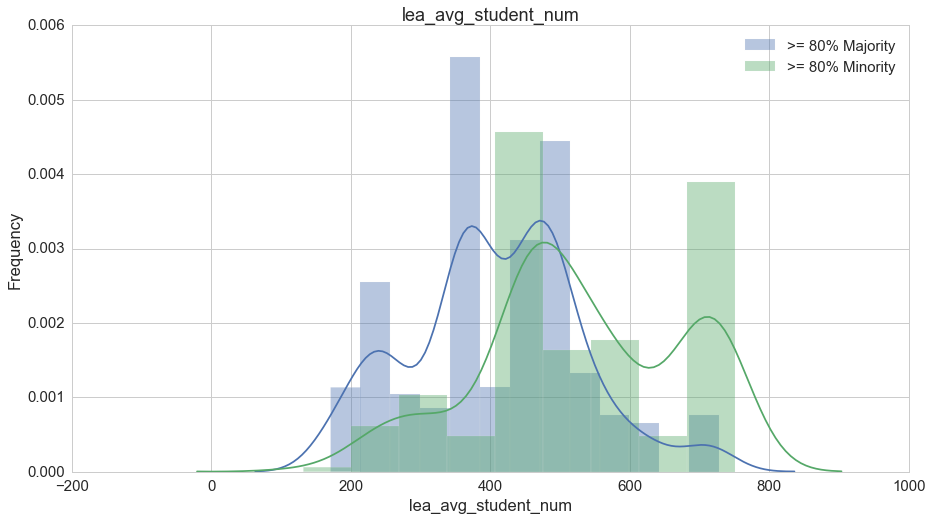

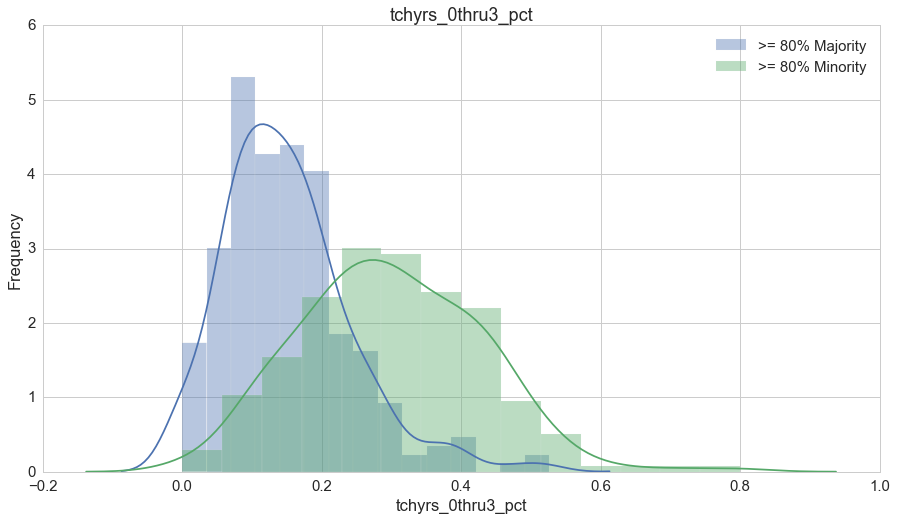

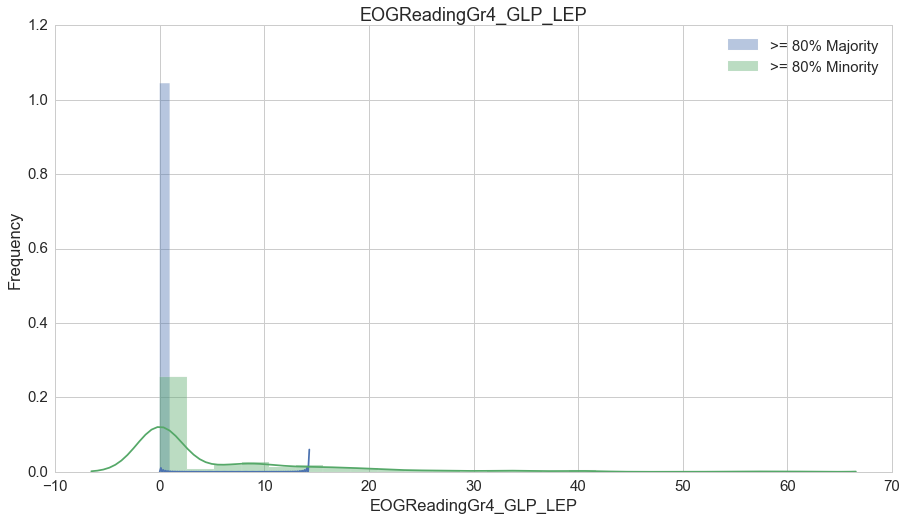

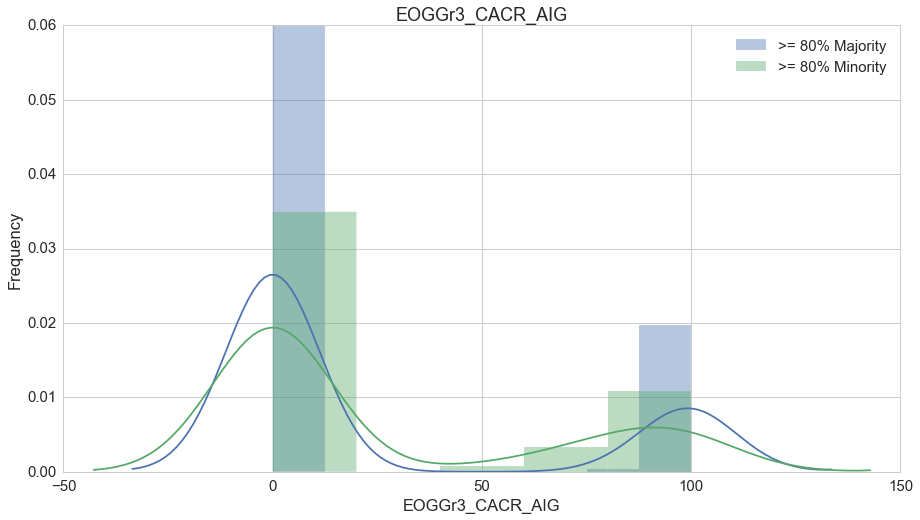

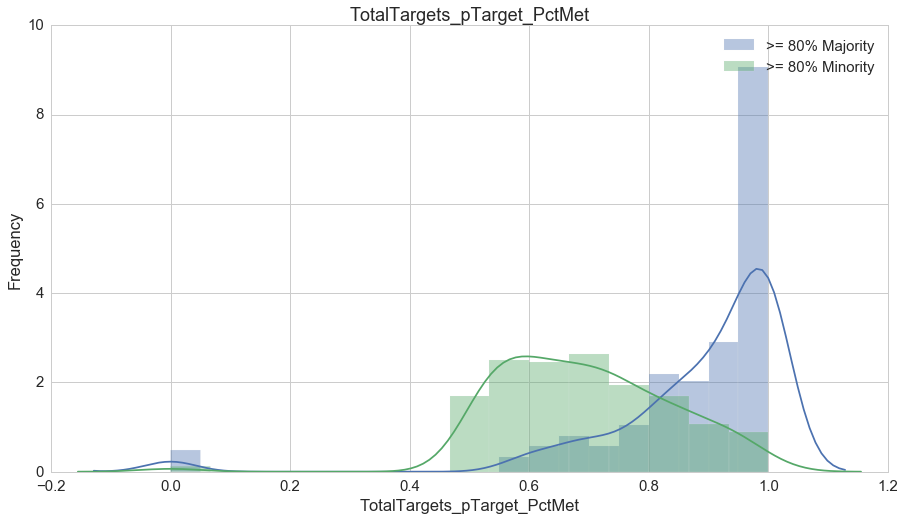

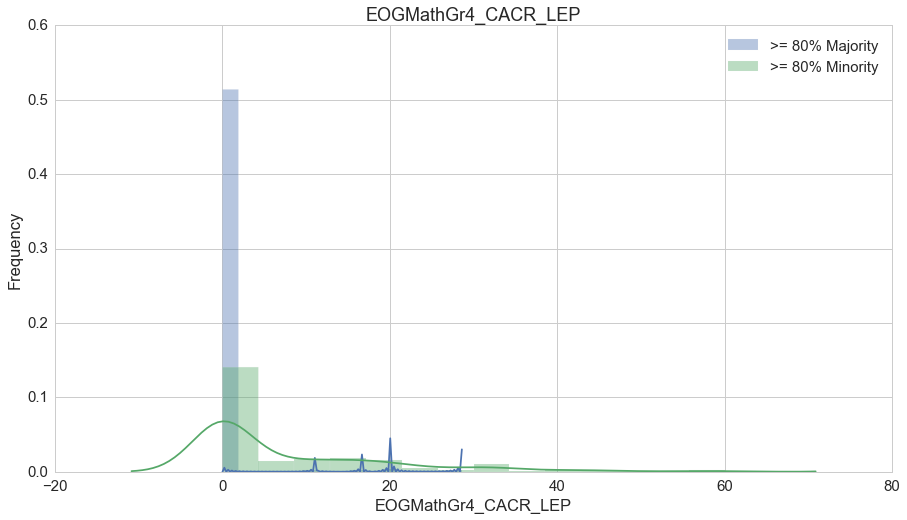

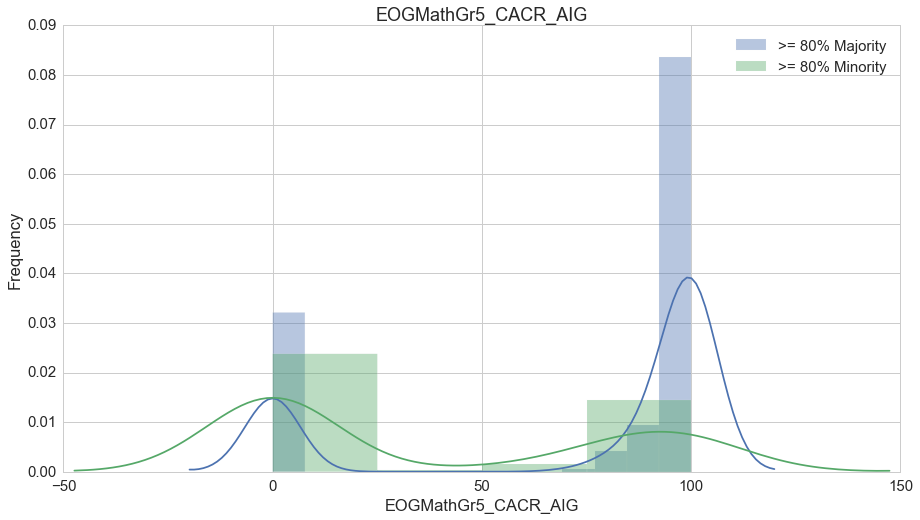

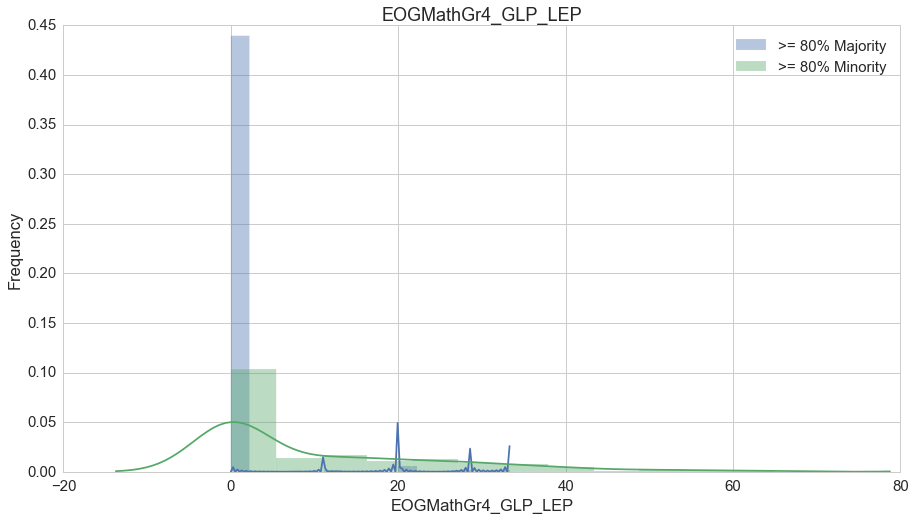

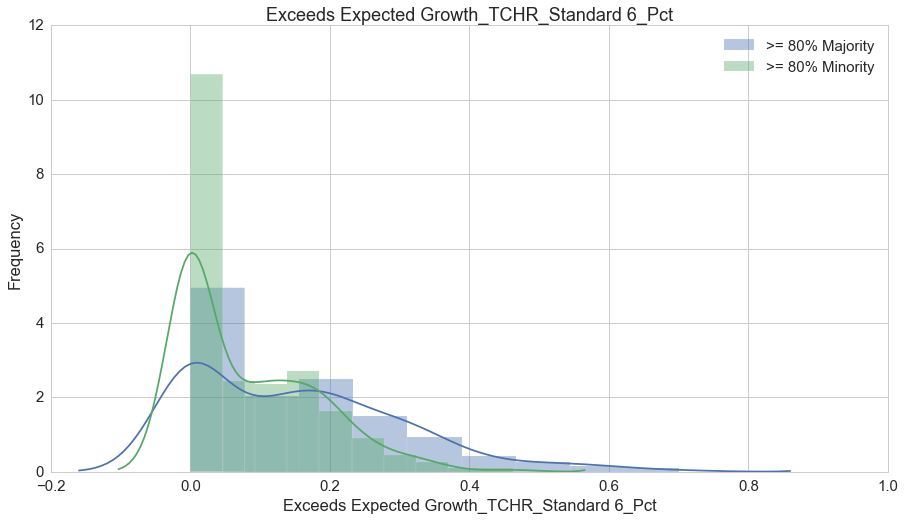

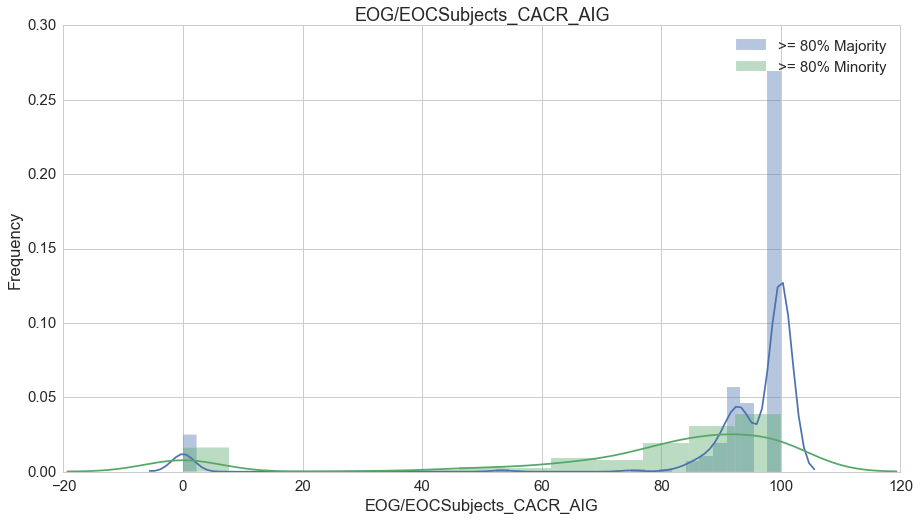

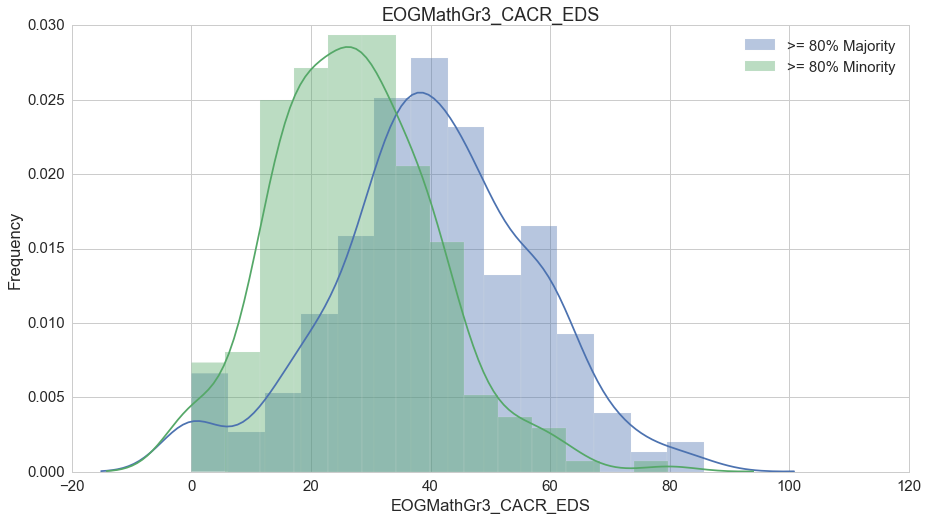

In [42]:
for col in top_features_df.loc[:,continuousMask].columns.values[:-1]:
    #set histogram plot preferences
    sns.set(context='notebook', style='whitegrid', font_scale=1.5)
    fig, ax=plt.subplots(figsize=(15,8))

    #Plot histogram of Books per Student
    sns.distplot(topContinuous[col].loc[topContinuous["HighlySegregatedType"] == ">= 80% Majority"])
    sns.distplot(topContinuous[col].loc[topContinuous["HighlySegregatedType"] == ">= 80% Minority"])

    # Set plot title, labels and legend
    #plt.xlim(0, 100)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(col)
    plt.legend([">= 80% Majority", ">= 80% Minority"])
    plt.show()